# LSTM Predictions for avalanche data
This notebook is going to go through how an LSTM model can be used to predict the avalanche danger levels in a given region

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

random.seed(42)
plt.style.use('fivethirtyeight')

2024-02-25 16:57:26.721690: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 16:57:26.895816: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 16:57:27.410451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 16:57:31.885386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading the data
First we load the data

In [2]:
df = pd.read_csv(filepath_or_buffer="weather_warning_combined.csv")
df["Time"] = pd.to_datetime(df["Time"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12973 entries, 0 to 12972
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   region_id                   12973 non-null  int64         
 1   region_name                 12973 non-null  object        
 2   temp_2m_max                 12973 non-null  float64       
 3   temp_2m_min                 12973 non-null  float64       
 4   temp_2m_mean                12973 non-null  float64       
 5   rain_sum                    12973 non-null  float64       
 6   snowfall_sum                12973 non-null  float64       
 7   windspeed_10m_max           12973 non-null  float64       
 8   windgusts_10m_max           12973 non-null  float64       
 9   winddirection_10m_dominant  12973 non-null  int64         
 10  DangerLevel                 12973 non-null  int64         
 11  Time                        12973 non-null  datetime64

In [3]:
df.drop(columns=["region_name"])

region_id  temp_2m_max  temp_2m_min  temp_2m_mean  rain_sum  \
0           3003        -19.3        -23.0         -21.5       0.0   
1           3003        -15.7        -20.2         -17.7       0.0   
2           3003        -16.6        -19.4         -17.4       0.0   
3           3003        -18.8        -24.1         -22.0       0.0   
4           3003        -15.3        -19.5         -18.0       0.0   
...          ...          ...          ...           ...       ...   
12968       3035         -0.4         -2.2          -1.2       0.0   
12969       3035          1.4         -0.7           0.4       0.2   
12970       3035          3.8          0.4           1.9       0.0   
12971       3035          8.0          3.1           6.7      19.4   
12972       3035          7.5          6.0           6.7      12.3   

       snowfall_sum  windspeed_10m_max  windgusts_10m_max  \
0              0.00                6.9               23.8   
1              0.00                6.0               21.2   
2              0.00                5.8               17.6   
3              0.21                9.4               20.9   
4              1.75               16.4               55.4   
...             ...                ...                ...   
12968          0.42               22.6               42.5   
12969          1.47               19.5               40.0   
12970          0.00               20.8               36.0   
12971          0.77               33.7               54.7   
12972          0.00               18.3               31.3   

       winddirection_10m_dominant  DangerLevel       Time  
0                              88            2 2018-01-01  
1                              53            2 2018-01-02  
2                              75            2 2018-01-03  
3                             101            2 2018-01-04  
4                              72            2 2018-01-05  
...                           ...          ...        ...  
12968                         118            1 2021-12-27  
12969                         109            1 2021-12-28  
12970                         124            1 2021-12-29  
12971                         209            2 2021-12-30  
12972                         214            2 2021-12-31  

[12973 rows x 11 columns]

## Building sequences

In [4]:
from tqdm import tqdm

def build_sequences(df, telescope=15):
    edit_df = df.copy(deep=True)
    # Sort the DataFrame by 'region_id' and 'Time'
    edit_df.sort_values(by=['region_id', 'Time'], inplace=True)
    
    # Create a list to store the resulting sequences
    sequences = []
    
    # Iterate through the DataFrame to create sequences
    for region_id, region_group in tqdm(edit_df.groupby('region_id')):
        for i in range(len(region_group) - (telescope-1)):
            sequence_data = region_group.iloc[i:i+telescope].copy()
            end_date = sequence_data['Time'].max()
            
            # Check for consecutive days within the sequence
            date_diff = sequence_data['Time'].diff().fillna(pd.Timedelta(days=1))
            if (date_diff == pd.Timedelta(days=1)).all():
                sequence_data['DayForDanger'] = end_date
                danger_level = sequence_data[sequence_data['Time'] == end_date]["DangerLevel"].values[0]
                sequence_data['SequenceDangerLevel'] = danger_level
                sequence_data['SequenceID'] = f"{region_id}-{end_date}"
                sequences.append(sequence_data)
    
    # Concatenate the sequences into a new DataFrame
    sequences_df = pd.concat(sequences)
    
    # Reset the index of the resulting DataFrame if needed
    sequences_df.reset_index(drop=True, inplace=True)
    sequences_df.drop(columns=["region_id", "region_name", "DayForDanger"], inplace=True)

    return sequences_df

In [5]:
sequences = build_sequences(df=df, telescope=15)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


In [6]:
sequences["SequenceID"].nunique()

9022

In [7]:
sequences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135330 entries, 0 to 135329
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   temp_2m_max                 135330 non-null  float64       
 1   temp_2m_min                 135330 non-null  float64       
 2   temp_2m_mean                135330 non-null  float64       
 3   rain_sum                    135330 non-null  float64       
 4   snowfall_sum                135330 non-null  float64       
 5   windspeed_10m_max           135330 non-null  float64       
 6   windgusts_10m_max           135330 non-null  float64       
 7   winddirection_10m_dominant  135330 non-null  int64         
 8   DangerLevel                 135330 non-null  int64         
 9   Time                        135330 non-null  datetime64[ns]
 10  SequenceDangerLevel         135330 non-null  int64         
 11  SequenceID                  135330 non-

In [8]:
def plot_random_sequences_with_label(data, num_of_sequences=2):
    # Randomly select sequences
    random_sequences = data['SequenceID'].unique().tolist()[:num_of_sequences]
    
    # Create separate plots for each sequence
    for sequence_id in random_sequences:
        sequence_data = data[data['SequenceID'] == sequence_id]
        danger_level = sequence_data['SequenceDangerLevel'].iloc[0]
        
        plt.figure(figsize=(10, 10))
        plt.suptitle(f'Sequence {sequence_id} (Danger Level {danger_level})')

        ax0 = plt.subplot(2, 2, 1)
        sns.lineplot(data=sequence_data, x='Time', y='DangerLevel', label='Daily Danger level')
        ax0.set_xlabel('Time')
        ax0.set_ylabel('Danger Level')
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.xticks(rotation=90)  # Rotate x-labels 90 degrees
        
        # Create subplots
        ax1 = plt.subplot(2, 2, 2)
        sns.lineplot(data=sequence_data, x='Time', y='temp_2m_mean', label='Mean temperature')
        plt.fill_between(sequence_data['Time'], sequence_data['temp_2m_max'], sequence_data['temp_2m_min'], alpha=0.2, color='lightblue')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Degrees (Celsius)')
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.xticks(rotation=90)  # Rotate x-labels 90 degrees

        ax2 = plt.subplot(2, 2, 3)
        sns.lineplot(data=sequence_data, x='Time', y='rain_sum', label='Total Rain')
        sns.lineplot(data=sequence_data, x='Time', y='snowfall_sum', label='Total Snowfall')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Millimeters')
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.xticks(rotation=90)  # Rotate x-labels 90 degrees

        ax3 = plt.subplot(2, 2, 4)
        sns.lineplot(data=sequence_data, x='Time', y='windspeed_10m_max', label='Windspeed (10m max)')
        sns.lineplot(data=sequence_data, x='Time', y='windgusts_10m_max', label='Wind Gusts (10m max)')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Wind speed (m/s)')
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.xticks(rotation=90)  # Rotate x-labels 90 degrees

        plt.legend()
        plt.show()

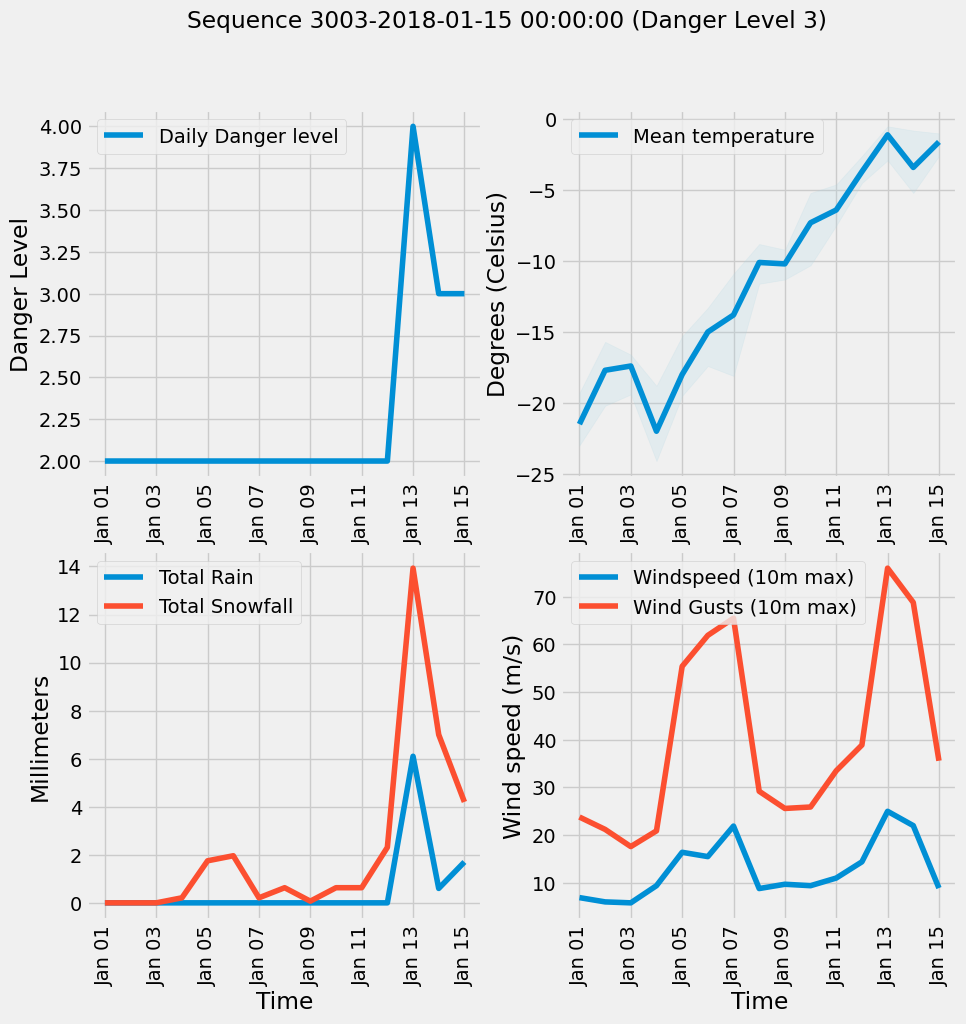

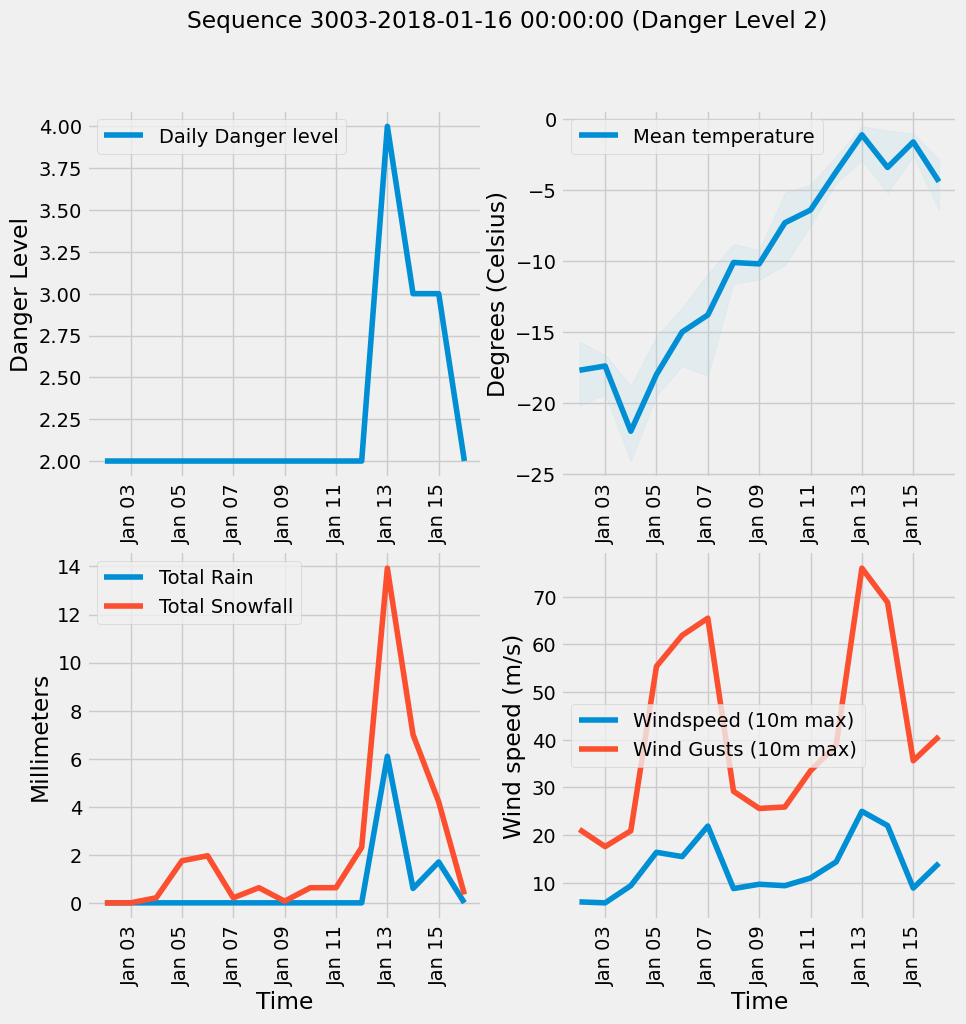

In [9]:
plot_random_sequences_with_label(sequences)

## Creating train, validation and test split

In [10]:
# Get unique sequence IDs
sequence_ids = sequences['SequenceID'].unique()

# Randomly shuffle sequence IDs
np.random.shuffle(sequence_ids)

# Determine the number of sequences to keep in the training set
train_size = int(0.8 * len(sequence_ids))
train_sequence_ids = sequence_ids[:train_size]

# Determine the number of sequences to keep in the validation set
validation_size = int(0.2 * len(train_sequence_ids))
validation_sequence_ids = train_sequence_ids[:validation_size]
train_sequence_ids = train_sequence_ids[validation_size:]

# Assign sequences to testing set
test_sequence_ids = sequence_ids[train_size:]

# Filter DataFrame based on sequence IDs
train_df = sequences[sequences['SequenceID'].isin(train_sequence_ids)]
validation_df = sequences[sequences['SequenceID'].isin(validation_sequence_ids)]
test_df = sequences[sequences['SequenceID'].isin(test_sequence_ids)]


In [11]:
features = ['temp_2m_max', 'temp_2m_min', 'temp_2m_mean', 'rain_sum',
       'snowfall_sum', 'windspeed_10m_max', 'windgusts_10m_max',
       'winddirection_10m_dominant']
target = "SequenceDangerLevel"

In [12]:
X_train = []
y_train = []
for seqId in tqdm(train_sequence_ids):
    X_train.append(train_df.loc[train_df["SequenceID"] == seqId][features].values) 
    y_train.append(train_df.loc[train_df["SequenceID"] == seqId][target].values[0])

X_validation = []
y_validation = []
for seqId in tqdm(validation_sequence_ids):
    X_validation.append(validation_df.loc[validation_df["SequenceID"] == seqId][features].values) 
    y_validation.append(validation_df.loc[validation_df["SequenceID"] == seqId][target].values[0])


X_test = []
y_test = []
for seqId in tqdm(test_sequence_ids):
    X_test.append(test_df.loc[test_df["SequenceID"] == seqId][features].values) 
    y_test.append(test_df.loc[test_df["SequenceID"] == seqId][target].values[0])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1805/1805 [00:09<00:00, 183.09it/s]


In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)
X_test = np.array(X_test)
y_test = np.array(y_test)


from keras.utils import to_categorical


y_train = y_train - 1
y_validation = y_validation - 1
y_test = y_test - 1

y_train = to_categorical(y_train, num_classes=4)
y_validation = to_categorical(y_validation, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Model construction

## Baseline

In [14]:
import numpy as np

# Define a function for the baseline model
def baseline_model(data):
    return np.array([[0, 1, 0, 0]]*data.shape[0])


## Simple LSTM network

In [15]:
def build_simple_lstm_network():
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(4, activation='softmax'))  
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
model = build_simple_lstm_network()

/home/vs/Development/Boreas/boreasvenv/lib64/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
from keras.callbacks import EarlyStopping


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4755 - loss: 1.1459 - val_accuracy: 0.5731 - val_loss: 0.9803
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5806 - loss: 0.9652 - val_accuracy: 0.6050 - val_loss: 0.9266
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5975 - loss: 0.9208 - val_accuracy: 0.6091 - val_loss: 0.9052
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6141 - loss: 0.8658 - val_accuracy: 0.6279 - val_loss: 0.8655
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6197 - loss: 0.8383 - val_accuracy: 0.6258 - val_loss: 0.8427
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6341 - loss: 0.8074 - val_accuracy: 0.6341 - val_loss: 0.8267
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6475 - loss: 0.7860 - val_accuracy: 0.6209 - val_loss: 0.8235
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6550 - loss: 0.7682 - val_accu

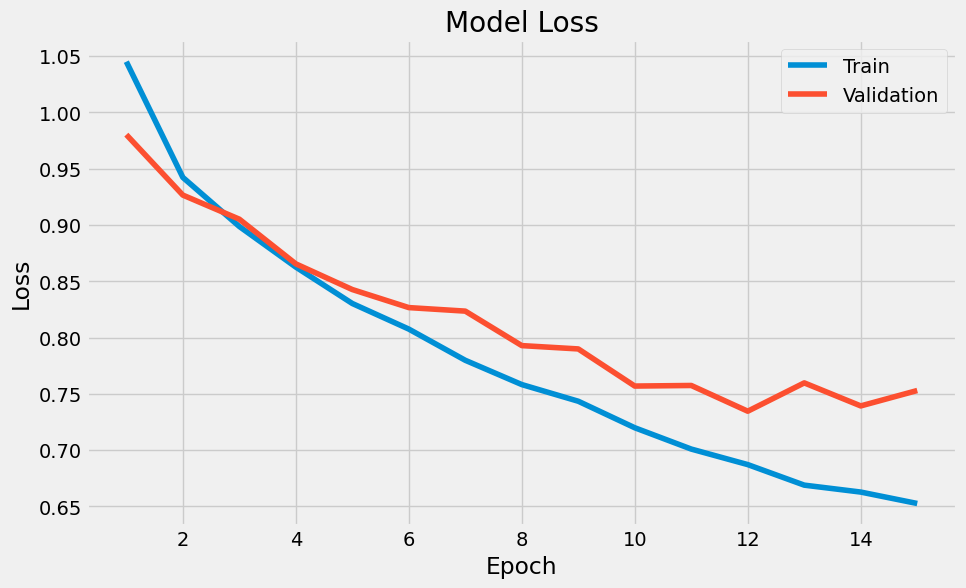

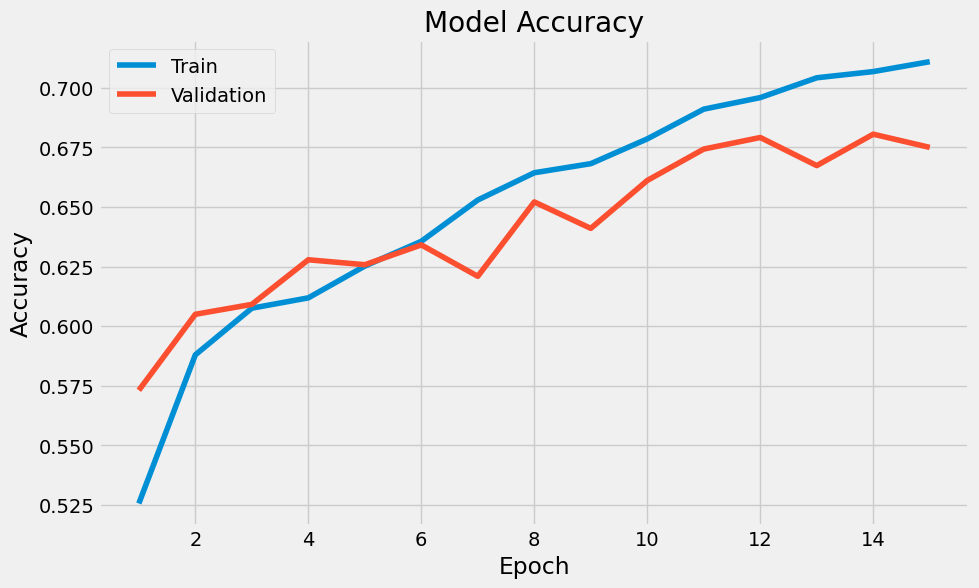

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Train')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Train')
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
model.save("models/simple_lstm.keras")

# Model Evaluation
In the evaluation part, we will look into the model's performance on the test set compared to a baseline model which always predicts the mode danger level (2)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming model is your trained model
# Evaluate your model on the validation set
y_pred_validation = model.predict(X_validation)
# Assuming y_validation is your true labels
# Convert y_pred_validation to class labels
y_pred_classes_validation = np.argmax(y_pred_validation, axis=1)
y_validation_classes = np.argmax(y_validation, axis=1)
print(y_pred_validation)

# Calculate evaluation metrics for your model
accuracy_validation = accuracy_score(y_validation_classes, y_pred_classes_validation)
precision_validation = precision_score(y_validation_classes, y_pred_classes_validation, average='weighted')
recall_validation = recall_score(y_validation_classes, y_pred_classes_validation, average='weighted')
f1_score_validation = f1_score(y_validation_classes, y_pred_classes_validation, average='weighted')


# Calculate evaluation metrics for the baseline model
# Assuming baseline_output is the output of your baseline_model function
# Convert baseline_output to class labels
baseline_output = baseline_model(X_validation)
baseline_pred_classes_validation = np.argmax(baseline_output, axis=1)

accuracy_baseline = accuracy_score(y_validation_classes, baseline_pred_classes_validation)
precision_baseline = precision_score(y_validation_classes, baseline_pred_classes_validation, average='weighted')
recall_baseline = recall_score(y_validation_classes, baseline_pred_classes_validation, average='weighted')
f1_score_baseline = f1_score(y_validation_classes, baseline_pred_classes_validation, average='weighted')



46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[7.8531548e-02 6.1159295e-01 3.0834728e-01 1.5280610e-03]
 [3.6513403e-03 8.3096690e-02 7.9028761e-01 1.2296439e-01]
 [8.6223006e-01 1.2869057e-01 8.9217955e-03 1.5756310e-04]
 ...
 [5.4047480e-02 6.6984731e-01 2.7381653e-01 2.2885946e-03]
 [7.9112571e-01 1.8509890e-01 2.3629008e-02 1.4650224e-04]
 [6.9529060e-03 2.5813431e-01 7.0381731e-01 3.1095453e-02]]


/home/vs/Development/Boreas/boreasvenv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


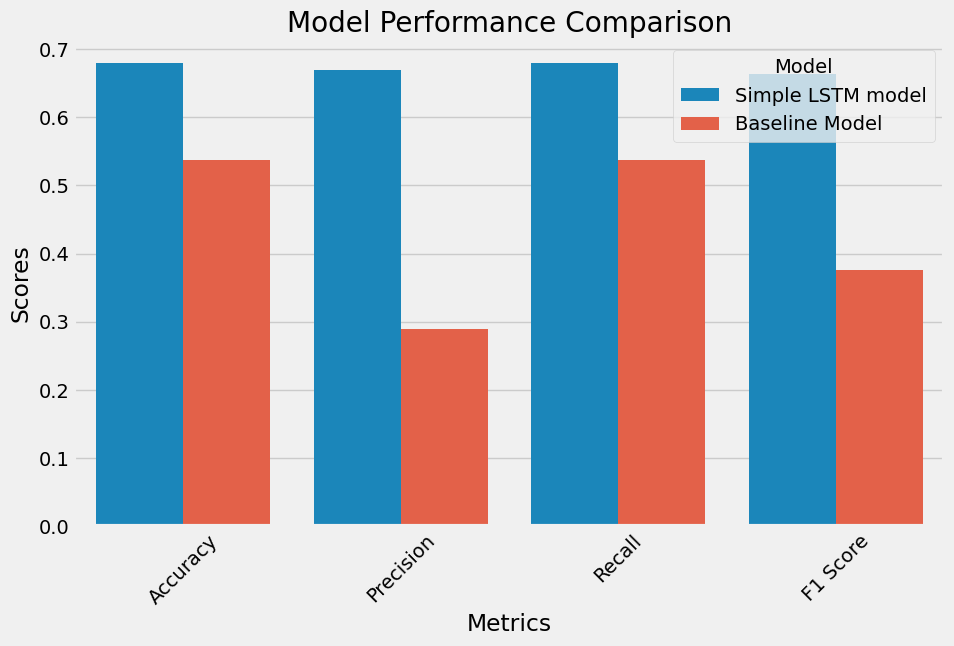

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define evaluation metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define scores for your model and baseline model
your_model_scores = [accuracy_validation, precision_validation, recall_validation, f1_score_validation]
baseline_model_scores = [accuracy_baseline, precision_baseline, recall_baseline, f1_score_baseline]

# Create a DataFrame for the scores
data = {
    'Metrics': metrics * 2,
    'Scores': your_model_scores + baseline_model_scores,
    'Model': ['Simple LSTM model'] * len(metrics) + ['Baseline Model'] * len(metrics)
}
df = pd.DataFrame(data)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrics', y='Scores', hue='Model', data=df)
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()


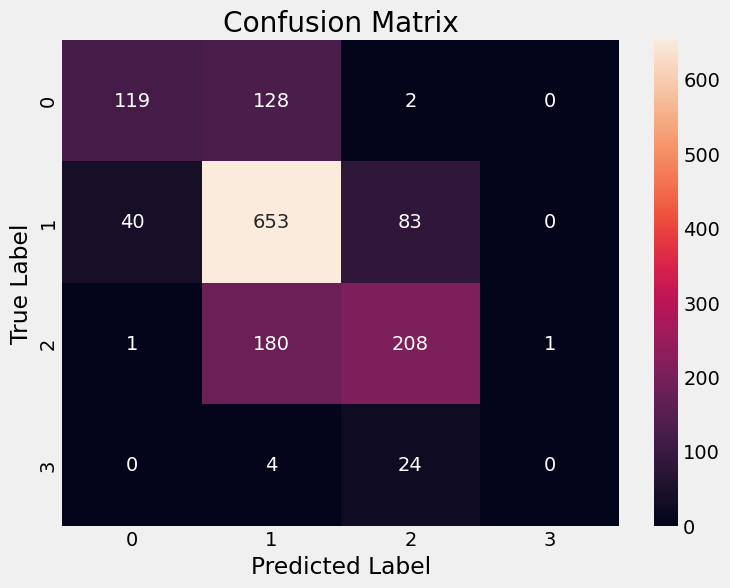

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions of your model on the validation set
y_pred_classes_validation = np.argmax(y_pred_validation, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_validation_classes, y_pred_classes_validation)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
